Team members:

Name: Xi Yu
StudentID: 22015116

Name: Chenxin Li
Student ID: 20066519


The second line in the book should be a comment stating if the code executes to the end without an error.

The third line in the book should be a comment with a link to the original source where you opted to reuse an existing implementation.


try cnn here, refer to https://www.kaggle.com/code/mdmosarrofhossen/brain-tumor-detection-accuracy-100-val-acc-100

kaggle dataset here: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

maybe not enough large. We will try to train and see the process time.

Add GPU to accelerate

In [ ]:
! pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 2.9 MB/s eta 0:00:00


In [ ]:
import time
start_time = time.time()

In [ ]:
! nvidia-smi

Wed Mar 22 11:29:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.device('/device:GPU:0')

Found GPU at: /device:GPU:0


In [ ]:
!rm -rf Brain_MRI_Image
! git clone https://github.com/TravellerXi/Brain_MRI_Image

Cloning into 'Brain_MRI_Image'...
remote: Enumerating objects: 3031, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 3031 (delta 4), reused 242 (delta 4), pack-reused 2789
Receiving objects: 100% (3031/3031), 78.64 MiB | 17.33 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
! ls

Brain_MRI_Image  sample_data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
dataset_train_dir = "Brain_MRI_Image/train/"
dataset_test_dir = "Brain_MRI_Image/test/"


In [ ]:

def image_gen(height, width):
    datagen_train = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            )
    train_ds = datagen_train.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    
    val_ds = datagen_train.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        subset="validation",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )

    datagen_test = ImageDataGenerator(
            rescale=1./255.,
            #validation_split=0.2,
            )
    test_ds = datagen_test.flow_from_directory(
        dataset_train_dir,
        batch_size=batch_size,
        #subset="training",
        shuffle=True,
        class_mode="binary",
        target_size=(height, width),
        classes={'no': 0., 'yes': 1.}
    )
    #val_batches = tf.data.experimental.cardinality(val_ds_total)
    #test_ds = val_ds.take((2*val_batches) // 3)
    #val_ds = val_ds.skip((2*val_batches) // 3)
    
    #return train_ds, val_ds, test_ds
    return train_ds, val_ds, test_ds
    

#train_ds, val_ds, test_ds = image_gen(height, width)
train_ds, val_ds, test_ds = image_gen(height, width)


total_images = np.concatenate([train_ds.labels, val_ds.labels])
print('\n\n',{"No brain tumor cases": len(np.where(total_images==0)[0]),
             "Brain tumor cases": len(np.where(total_images==1)[0])})

#print(test_ds.labels)
#print(test_ds[0][0].shape)
  


Found 2469 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 3085 images belonging to 2 classes.


 {'No brain tumor cases': 474, 'Brain tumor cases': 2611}


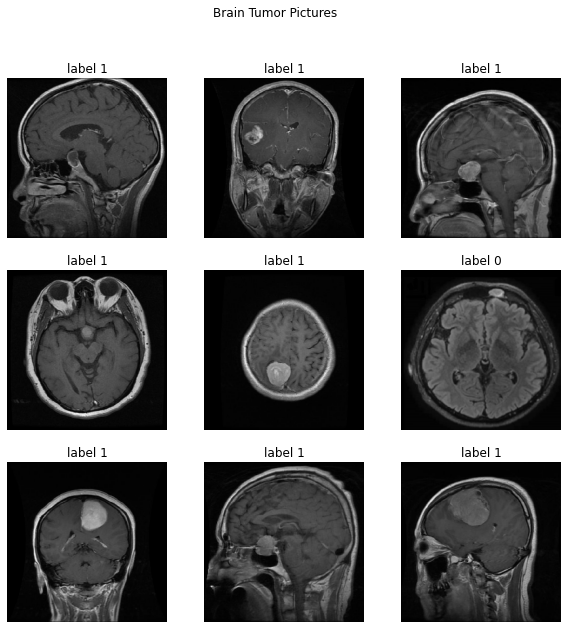

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

 train a ResNet50V2 starting from here

In [ ]:
from keras.applications import ResNet50V2
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.models import Sequential, load_model

In [ ]:
! pip install scikit-optimize
! pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.7 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV as BS
n_iterations = 50
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
import keras_tuner

## this time, we refer to https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=zh-cn

In [ ]:
def build_model(hp):
  tf.keras.backend.clear_session()
  model = ResNet50V2(input_shape=(244,244,3), include_top=False,pooling="avg")
  model.trainable = True
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
               loss="sparse_categorical_crossentropy", 
               metrics=['accuracy'])
  return model


In [ ]:
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    #overwrite=True,
    
    )

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]
tuner.search(train_ds, epochs=30, validation_data=val_ds,callbacks=callbacks_list)
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#best_model.trainable = True

Trial 90 Complete [00h 04m 05s]
val_accuracy: 0.15259739756584167

Best val_accuracy So Far: 0.9431818127632141
Total elapsed time: 03h 30m 48s


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

print(f"Best hyperparameters: {best_hps}")

Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fb6cd432130>


In [ ]:
print(f"""The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

The optimal learning rate for the optimizer
is 0.0001.



In [ ]:
! cd /content/gdrive/MyDrive && ls

'Colab Notebooks'   data1.csv   grape   kaggle.json   xi.bnf


In [ ]:
model = tuner.hypermodel.build(best_hps)
from kerastuner import HyperParameters
hp = HyperParameters()
best_model.get_config()
model.save("/content/gdrive/MyDrive/best_hps_model")

In [ ]:
!cd /content/gdrive/MyDrive && ls

 best_hps_model  'Colab Notebooks'   data1.csv	 grape	 kaggle.json   xi.bnf


In [ ]:
print(model.optimizer.lr)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
